Training with custom Adam optimizer with Morse theory and Floer Homotopy:
Epoch 0, Loss: 5.5411
Epoch 100, Loss: 0.9905
Epoch 200, Loss: 0.2716
Epoch 300, Loss: 0.2221
Epoch 400, Loss: 0.2209
Epoch 500, Loss: 0.2209
Epoch 600, Loss: 0.2209
Epoch 700, Loss: 0.2209
Epoch 800, Loss: 0.2209
Epoch 900, Loss: 0.2209
Training with built-in Adam optimizer:
Epoch 0, Loss: 7.5013
Epoch 100, Loss: 2.6024
Epoch 200, Loss: 0.7763
Epoch 300, Loss: 0.3085
Epoch 400, Loss: 0.2300
Epoch 500, Loss: 0.2215
Epoch 600, Loss: 0.2209
Epoch 700, Loss: 0.2209
Epoch 800, Loss: 0.2209
Epoch 900, Loss: 0.2209
Training with built-in AdamW optimizer:
Epoch 0, Loss: 10.6372
Epoch 100, Loss: 4.5297
Epoch 200, Loss: 1.7258
Epoch 300, Loss: 0.6662
Epoch 400, Loss: 0.3343
Epoch 500, Loss: 0.2474
Epoch 600, Loss: 0.2276
Epoch 700, Loss: 0.2232
Epoch 800, Loss: 0.2220
Epoch 900, Loss: 0.2217
Training with Lion optimizer:
Epoch 0, Loss: 9.6738
Epoch 100, Loss: 9.6738
Epoch 200, Loss: 9.6738
Epoch 300, Loss: 9.6738
Epoch 40

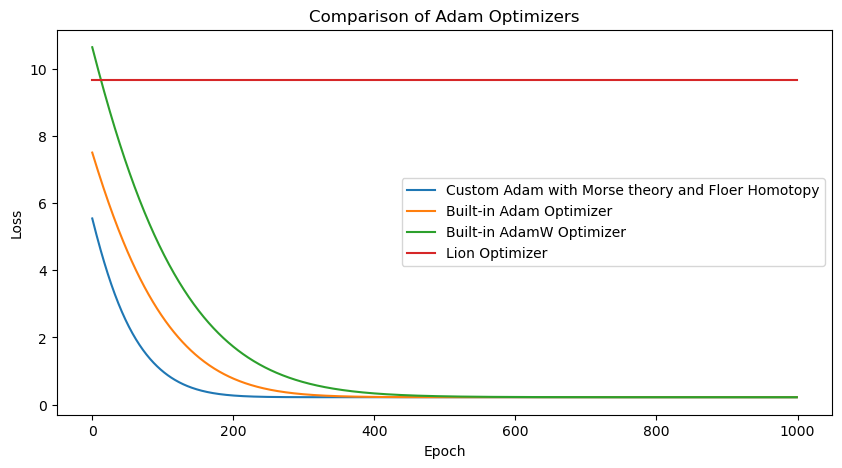

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from lion_pytorch import Lion


np.random.seed(42)
torch.manual_seed(42)

# Generate synthetic data
x = np.random.randn(100)
y = 2 * x + 3 + np.random.randn(100) * 0.5  # true slope is 2, intercept is 3
x = torch.tensor(x, dtype=torch.float32).view(-1, 1)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# Define a simple linear regression model
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)

    
class AdamOptimizerWithMorse(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        if not 0.0 <= lr:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= eps:
            raise ValueError(f"Invalid epsilon value: {eps}")
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 0: {betas[0]}")
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 1: {betas[1]}")

        defaults = dict(lr=lr, betas=betas, eps=eps)
        super(AdamOptimizerWithMorse, self).__init__(params, defaults)

    def floer_homotopy_perturbation(self, params, iteration):
        """Generate a Floer homotopy perturbation based on the current parameters and iteration count."""
        perturbation_strength = 0.0001 / (1 + iteration * 1e-3)
        perturbation = torch.sin(params) * perturbation_strength
        return perturbation

    def aggregate_curvature(self, exp_avg_sq):
        """Estimate average curvature using the exponential average of squared gradients."""
        curvature = exp_avg_sq.sqrt().mean()
        return curvature

    def classify_critical_point(self, grad, curvature):
        """Classify points as min, max, or saddle based on gradient norm and estimated curvature."""
        norm_grad = torch.norm(grad)
        if norm_grad < 1e-4:
            if curvature > 0:
                return 'min'
                print("min")
            elif curvature < 0:
                return 'max'
            else:
                return 'saddle'
        else:
            return 'saddle'

    def step(self, closure=None):
        """Performs a single optimization step (parameter update)."""
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                # Update estimates
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                denom = exp_avg_sq.sqrt().add_(group['eps'])
                step_size = group['lr'] * (np.sqrt(1 - beta2 ** state['step']) / (1 - beta1 ** state['step']))

                # Aggregate curvature across all parameters
                curvature = self.aggregate_curvature(exp_avg_sq)

                # Classify the critical point
                critical_point_type = self.classify_critical_point(grad, curvature)

                if critical_point_type == 'saddle':
                    step_size *= 1.5  # Increase step size at saddle points
                elif critical_point_type == 'min':
                    perturbation = self.floer_homotopy_perturbation(p.data, state['step'])
                    exp_avg.add_(perturbation)  # Apply Floer homotopy perturbation to the average gradient
                    step_size *= 0.1 # Decrease step size at minima for finer steps

                p.data.addcdiv_(-step_size, exp_avg, denom)

        return loss


# Training setup
model = LinearRegressionModel()
criterion = nn.MSELoss()

# Using the custom optimizer
optimizer_custom = AdamOptimizerWithMorse(model.parameters(), lr=0.01)
# Using the built-in Adam optimizer
optimizer_adam = optim.Adam(model.parameters(), lr=0.01)
# Using the built-in AdamW optimizer
optimizer_adamw = optim.AdamW(model.parameters(), lr=0.01)

optimizer_lion = Lion(model.parameters(), lr=0.001)


# Training loop
def train_model(optimizer, epochs=1000):
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
    return losses

# Train with custom optimizer
print("Training with custom Adam optimizer with Morse theory and Floer Homotopy:")
losses_custom = train_model(optimizer_custom)

# Reset model and optimizer
model = LinearRegressionModel()
optimizer_adam = optim.Adam(model.parameters(), lr=0.01)

# Train with built-in Adam optimizer
print("Training with built-in Adam optimizer:")
losses_adam = train_model(optimizer_adam)

# Reset model and optimizer
model = LinearRegressionModel()
optimizer_adamw = optim.AdamW(model.parameters(), lr=0.01)

# Train with built-in AdamW optimizer
print("Training with built-in AdamW optimizer:")
losses_adamw = train_model(optimizer_adamw)


# Reset model and optimizer
model = LinearRegressionModel()
optimizer_adamw = optim.AdamW(model.parameters(), lr=0.01)

# Train with Lion optimizer
print("Training with Lion optimizer:")
losses_lion = train_model(optimizer_lion)


# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(losses_custom, label='Custom Adam with Morse theory and Floer Homotopy')
plt.plot(losses_adam, label='Built-in Adam Optimizer')
plt.plot(losses_adamw, label='Built-in AdamW Optimizer')
plt.plot(losses_lion, label='Lion Optimizer')
plt.title("Comparison of Adam Optimizers")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


Training with custom Adam optimizer with Morse theory and Floer Homotopy:
Epoch [1/20], Loss: 0.2967
Epoch [2/20], Loss: 0.1402
Epoch [3/20], Loss: 0.1081
Epoch [4/20], Loss: 0.0895
Epoch [5/20], Loss: 0.0795
Epoch [6/20], Loss: 0.0693
Epoch [7/20], Loss: 0.0643
Epoch [8/20], Loss: 0.0552
Epoch [9/20], Loss: 0.0511
Epoch [10/20], Loss: 0.0479
Epoch [11/20], Loss: 0.0473
Epoch [12/20], Loss: 0.0426
Epoch [13/20], Loss: 0.0419
Epoch [14/20], Loss: 0.0359
Epoch [15/20], Loss: 0.0408
Epoch [16/20], Loss: 0.0328
Epoch [17/20], Loss: 0.0339
Epoch [18/20], Loss: 0.0331
Epoch [19/20], Loss: 0.0288
Epoch [20/20], Loss: 0.0311
Training with built-in Adam optimizer:
Epoch [1/20], Loss: 0.3170
Epoch [2/20], Loss: 0.1444
Epoch [3/20], Loss: 0.1043
Epoch [4/20], Loss: 0.0859
Epoch [5/20], Loss: 0.0738
Epoch [6/20], Loss: 0.0622
Epoch [7/20], Loss: 0.0541
Epoch [8/20], Loss: 0.0472
Epoch [9/20], Loss: 0.0444
Epoch [10/20], Loss: 0.0419
Epoch [11/20], Loss: 0.0365
Epoch [12/20], Loss: 0.0340
Epoch [13

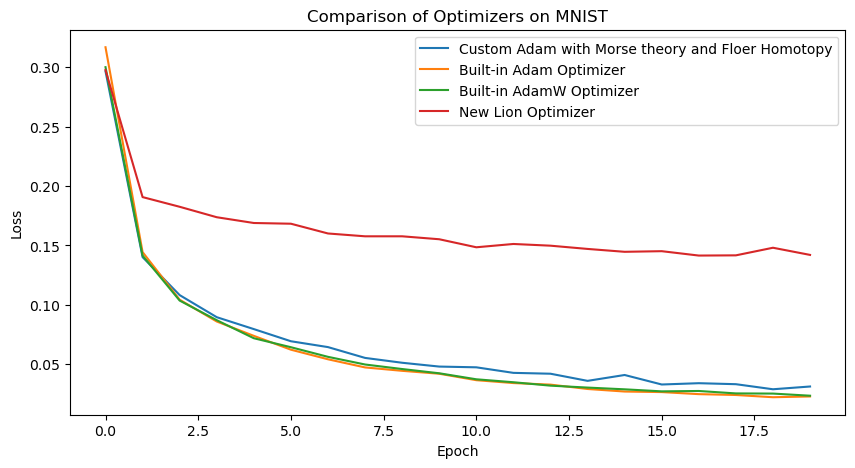

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from lion_pytorch import Lion


torch.cuda.is_available()

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)

# Define a simple neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training function
def train_model(model, optimizer, criterion, trainloader, epochs=20):
    model.train()
    losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(trainloader)
        losses.append(avg_loss)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')
    return losses

# Testing function
def test_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Initialize model, criterion, and optimizers
model_custom = Net()
model_adam = Net()
model_adamw = Net()
model_lion = Net()

criterion = nn.CrossEntropyLoss()

optimizer_custom = AdamOptimizerWithMorse(model_custom.parameters(), lr=0.001)
optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.001)
optimizer_adamw = optim.AdamW(model_adamw.parameters(), lr=0.001)
optimizer_lion = Lion(model_lion.parameters(), lr=0.001)


# Train and test models
print("Training with custom Adam optimizer with Morse theory and Floer Homotopy:")
losses_custom = train_model(model_custom, optimizer_custom, criterion, trainloader)

print("Training with built-in Adam optimizer:")
losses_adam = train_model(model_adam, optimizer_adam, criterion, trainloader)

print("Training with built-in AdamW optimizer:")
losses_adamw = train_model(model_adamw, optimizer_adamw, criterion, trainloader)

print("Training with Lion optimizer:")
losses_lion = train_model(model_lion, optimizer_lion, criterion, trainloader)

# Test accuracy
accuracy_custom = test_model(model_custom, testloader)
accuracy_adam = test_model(model_adam, testloader)
accuracy_adamw = test_model(model_adamw, testloader)
accuracy_lion = test_model(model_lion, testloader)

print(f"Custom Adam with Morse theory and Floer Homotopy: {accuracy_custom:.2f}%")
print(f"Built-in Adam Accuracy: {accuracy_adam:.2f}%")
print(f"Built-in AdamW Accuracy: {accuracy_adamw:.2f}%")
print(f"New Lion Accuracy: {accuracy_lion:.2f}%")


# Plotting the results
plt.figure(figsize=(10, 5))
plt.plot(losses_custom, label='Custom Adam with Morse theory and Floer Homotopy')
plt.plot(losses_adam, label='Built-in Adam Optimizer')
plt.plot(losses_adamw, label='Built-in AdamW Optimizer')
plt.plot(losses_lion, label='New Lion Optimizer')
plt.title("Comparison of Optimizers on MNIST")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()